
# Simulating and fitting a time varying source

We simulate and fit a time decaying light curve of a source using the CTA 1DC response. <br>
<br>
Comment for the reader:<br>
<br>
For this sample code we will simulate 10 spectral datasets within given time intervals (Good
Time Intervals) following a given spectral (a power law) and temporal
profile (an exponential decay, with a decay time of 6 hr for now ). Then we will
analyse them using the light curve estimator to obtain flux points. Given the observation parameters, we will work for this case with IRFs obtained considering 5 hours of observation.<br>
These parameters can easily be changed throughout the notebook to study different sources. All the main parameters are defined in the second code cell, so that all changes can be done there.



In [1]:
import logging
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

# %matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

from astropy.io import fits

log = logging.getLogger(__name__)

from gammapy.data import Observation, observatory_locations
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    PowerLawSpectralModel,
    SkyModel,
)
import matplotlib.gridspec as gridspec
import warnings

## Monitoring arrays selection

In [2]:
file_directory = '' #Path to the IRFs files, typically to the IRFsobt folder
#By default until I say otherwise it will be here
file_directory_modified = '' #Path to this file
# ------------TO CHANGE------------
file_list = ['', #Name of the IRFs files in the file_directory end location
             '',
             '',
             '']
#------------TO CHANGE------------
legendsdic=['', #Legend for each studied configuration
         '',
         '',
         '']
obs_times='5h'
#------------VARIABLE SOURCE PARAMETERS TO CHANGE IF NEEDED------------
index_source= 2.2; amplitude_source="2 10e-11 cm-2 s-1 TeV-1"; t0_source='6h' #10e-12 if you wanna do testings
#OBSERVATION PARAMETERS TO CHANGE IF NEEDED
gti_t0 = Time("2020-03-01")
n_obs = 10 #Number of observations. Right now there is one observation for energy bin
#Start times for each observation. Each element represents the time difference (in hours) between the gti_t0 and the start time of a specific observation
tstart = gti_t0 + [1, 2, 3, 5, 8, 10, 20, 22, 23, 24] * u.h 
#Live times (exposure times) for each observations. Each element represents the live time in minutes for a specific observation. Basically the effective time duration for which the detector was
#actively recording data during each observation.
lvtm = [55, 25, 26, 40, 40, 50, 40, 52, 43, 47] * u.min
#------------FITTING STRATEGY MINUIT-------------
#------------TO CHANGE------------
fitting_strategy_minuit=2
minuit_opts = {"tol": 0.001, "strategy": fitting_strategy_minuit} 
#------------ENERGY EDGES FOR THE FITS------------
energy_edges_plot=[ 0.01, 0.3, 0.6, 1.0, 10] 


Code to put more paramters on the spectral model: <br>
model = LogParabolaSpectralModel(
    alpha=2.3,
    amplitude="1e-12 cm-2 s-1 TeV-1",
    reference=1 * u.TeV,
    beta=0.5,
)

## Variable Source set-up

In [3]:
#Common for everyone
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-2, 1.0, 10), unit="TeV", name="energy", interp="log" #It will range between 10^(-2) and 10^(1.0) in 10 steps
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-2.5, 2.0, 41), unit="TeV", name="energy_true", interp="log" #It will range between 10^(-2.5) and 10^(2.0) 
)

geom = RegionGeom.create("galactic;circle(0, 0, 0.11)", axes=[energy_axis])
#it defines a circular region centered at galactic coordinates (0, 0) with a radius of 0.11 degrees. This geometry will be used to select events within this region for analysis.

# Pointing position
pointing = SkyCoord(0 ,0 , unit="deg", frame="galactic") # The wobble here is set to 0
##################################################################################################################
# Define the source model: A combination of spectral and temporal model


spectral_model = PowerLawSpectralModel( 
    index=index_source, amplitude=amplitude_source, reference="1 TeV"
)
#The index is the spectral index, whih describes the shape of the energy spectrum of the source. They characterize the type of emossion process occurring in the astrophysical sources
#An index=3 corresponds to a relatively steep power-law distribution, emaning that the source emits relatively fewer high-energy photons compared to lower-energy photons
#The amplitude "1e-11 cm-2 s-1 TeV-1" represents the overall flux normalization at 1 TeV
temporal_model = ExpDecayTemporalModel(t0=t0_source, t_ref=gti_t0.mjd * u.d) #We pass the reference time to julian dates and we have an exponentially decaying source over time which in 6h will have
#around 37% of its intensity

model_simu = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="model-simu",
)
#With SkyModel we combine both models to represent a a gamma-ray source with both spectral and temporal characteristics. This combination of models allows for simulating the behavior of a gamma-ray
#  source in both energy and time domains.

# Look at the model
display(model_simu.parameters.to_table()) #Display of the parameter values for both the spectral and temporal models
#A temporal model accounts for the distribution of how the intensity of emission from a source changes over time
#A spectral model accounts for the distribution of emitted or detected radiationas a function of energy.
#################################################################################################################

/Users/julialagunamiralles/opt/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/julialagunamiralles/opt/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str22,int64,float64,float64,bool,bool,str1
spectral,index,2.2000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,2.0000e+00,10**-10 cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,6.0000e+00,h,0.000e+00,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


## IRFs from the monitoring arrays we want to test

In [4]:
import os
# Changes in the headings of the IRFs files we need to make to use the gammapy functions
final_filelist=[]
for file_name in file_list:
    new_fits_file = 'modified_'+file_name
    fits_file = os.path.join(file_directory, file_name)
    print(fits_file)
    # Open the FITS file
    hdulist = fits.open(fits_file)
    # Replace 'hdu_index' with the index of the HDU whose name you want to change
    hdu_index = 4  
    hdu = hdulist[hdu_index]
    # Modify the name of the HDU
    hdu_name = 'EFFECTIVE AREA'
    hdu.header['EXTNAME'] = hdu_name
    # Save the modified HDU list with the new HDU name to a new FITS file
    hdulist.writeto(new_fits_file, overwrite=True)
    # Close the HDU list after writing
    hdulist.close()
    new_fits_file = os.path.join(file_directory_modified, new_fits_file)
    #
    final_filelist.append(new_fits_file)

/Users/julialagunamiralles/Desktop/Universitat/DESY/GammaProject/DL2-data-2023/DL2/DL3/irfsobt/pyirfs_alpha_5h.fits.gz
/Users/julialagunamiralles/Desktop/Universitat/DESY/GammaProject/DL2-data-2023/DL2/DL3/irfsobt/pyirfs_SV05b_5h.fits.gz
/Users/julialagunamiralles/Desktop/Universitat/DESY/GammaProject/DL2-data-2023/DL2/DL3/irfsobt/pyirfs_SV05c_5h.fits.gz
/Users/julialagunamiralles/Desktop/Universitat/DESY/GammaProject/DL2-data-2023/DL2/DL3/irfsobt/pyirfs_SV05d_5h.fits.gz


In [5]:
TimeMapAxis.time_format = "iso"

## We perform the simulations for each observation and extract the corresponding lightcurve

In [6]:
#For each IRF file we have indicated
#Loop format
#IRF loading
colors= ['red', 'purple', 'orange', 'green', 'aquamarine', 'blue', 'yellow']
lc_1ddic = {}
datasetssim= {}
datasetsdic= {}
for i, irffile in enumerate(final_filelist):

    irfs = load_irf_dict_from_file(irffile) 
    #--------------------BEGINNING SIMULATIONS FOR EACH OBSERVATION IN RANGE(N_OBS)-------------------------
    ##WE PERFORM THE SIMULATIONS FOR EACH OBSERVATION IN N_OBS
    datasetssim[f'datasim_{i}'] = Datasets()

    empty = SpectrumDataset.create(
        geom=geom, energy_axis_true=energy_axis_true, name="empty"
    )
    #An empty SpectrumDataset is created with the provided geometry (geom) and true energy axis (energy_axis_true).

    maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])
    #We create an object specifying which components should be included in the dataset creation process: "exposure", "background", and "edisp" (energy dispersion).

    for idx in range(n_obs):
        obs = Observation.create( #it contains the already defined parameters for each to be simulated observation
            pointing=pointing,
            livetime=lvtm[idx],
            tstart=tstart[idx],
            irfs=irfs,
            reference_time=gti_t0,
            obs_id=idx,
            location=observatory_locations["cta_north"],
        )
        empty_i = empty.copy(name=f"dataset-{idx}") #A copy of empty for each observation
        dataset = maker.run(empty_i, obs) #We create a data set for the observation with all the information from obs (obs) and the provided geometry and true energy axis (empty_i)
        dataset.models = model_simu #We copy the predefined model for each observation
        dataset.fake() #We generate simulated counts for the dataset based on the given assigned model and observation parameters
        datasetssim[f'datasim_{i}'].append(dataset) #The generated dataset is added to the container of datasets
        #Generating simulated counts for a dataset means creating a set of artificial data that represents what the actual data from an observation might look like, given a particular
        #  model and the parameters of the observation.
    #--------------------END SIMULATIONS-------------------------
    #WE EXTRACT THE LIGHT CURVE. SINCE THE ESTIMATOR RETURNS THE INTEGRATED FLUX SEPARATELY FOR EACH TIME BIN, WE DON'T NEED TO DEFINE THE TEMPORAL MODEL, ONLY THE SPECTRAL ONE
    model_fit = SkyModel(spectral_model=spectral_model, name="model-fit")
    # We define an object with the overall model used for fitting the observed data. That's why it's the same one, because we want to see how well is the fit between
    #the actual model and the detection results.

    # Attach model to all datasets
    datasetssim[f'datasim_{i}'].models = model_fit
    #By assigning the model_fit to the models attribute of the datasets object, the same spectral model will be associated with all the datasets in the collection.
    #Now we create a 1-dimensional light curve using a specific energy binning (the one we provide here, not the one before) for our set of datasets and 
    #the model-fit we have associated to it.
    lc_maker_1d = LightCurveEstimator(
        energy_edges=energy_edges_plot * u.TeV, #The energy ranges for which the light curve will be calculated.
        source="model-fit", #The source model to be used for the light curve calculation
        selection_optional=["ul"], #Additional selection criteria for the light curve calculation. In this case, "ul" indicates that upper limits will be included in
        # the light curve calculation. Upper limits represent situations where the observed counts are consistent with zero and can't be used to determine the source 
        #flux directly.
    )
    #
    #THIS IS THE LIGHTCURVE. WHAT WE USE TO PLOT THE FLUX VS TIME
    lc_1ddic[f"lc_1d_{i}"]: dict = lc_maker_1d.run(datasetssim[f'datasim_{i}']) #the run() method processes the datasets and computes the light curve using the specified energy binning and the other parameters.
    #After the code has been executed, the variable lc_1d will contain the calculated 1-dimensional light curve information, including flux measurements and upper limits in the specified energy bins.
    

more than one HDU of aeff type found
loaded the EFFECTIVE AREA HDU in the dictionary
more than one HDU of edisp type found
loaded the ENERGY_DISPERSION HDU in the dictionary
more than one HDU of aeff type found
loaded the EFFECTIVE AREA HDU in the dictionary
more than one HDU of edisp type found
loaded the ENERGY_DISPERSION HDU in the dictionary
more than one HDU of aeff type found
loaded the EFFECTIVE AREA HDU in the dictionary
more than one HDU of edisp type found
loaded the ENERGY_DISPERSION HDU in the dictionary
more than one HDU of aeff type found
loaded the EFFECTIVE AREA HDU in the dictionary
more than one HDU of edisp type found
loaded the ENERGY_DISPERSION HDU in the dictionary
more than one HDU of aeff type found
loaded the EFFECTIVE AREA HDU in the dictionary
more than one HDU of edisp type found
loaded the ENERGY_DISPERSION HDU in the dictionary
more than one HDU of aeff type found
loaded the EFFECTIVE AREA HDU in the dictionary
more than one HDU of edisp type found
loaded 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/1l/vydck6jn2r3g9d3rypt4jf240000gn/T/ipykernel_40820/1210967290.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(time_labels,  rotation=0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists

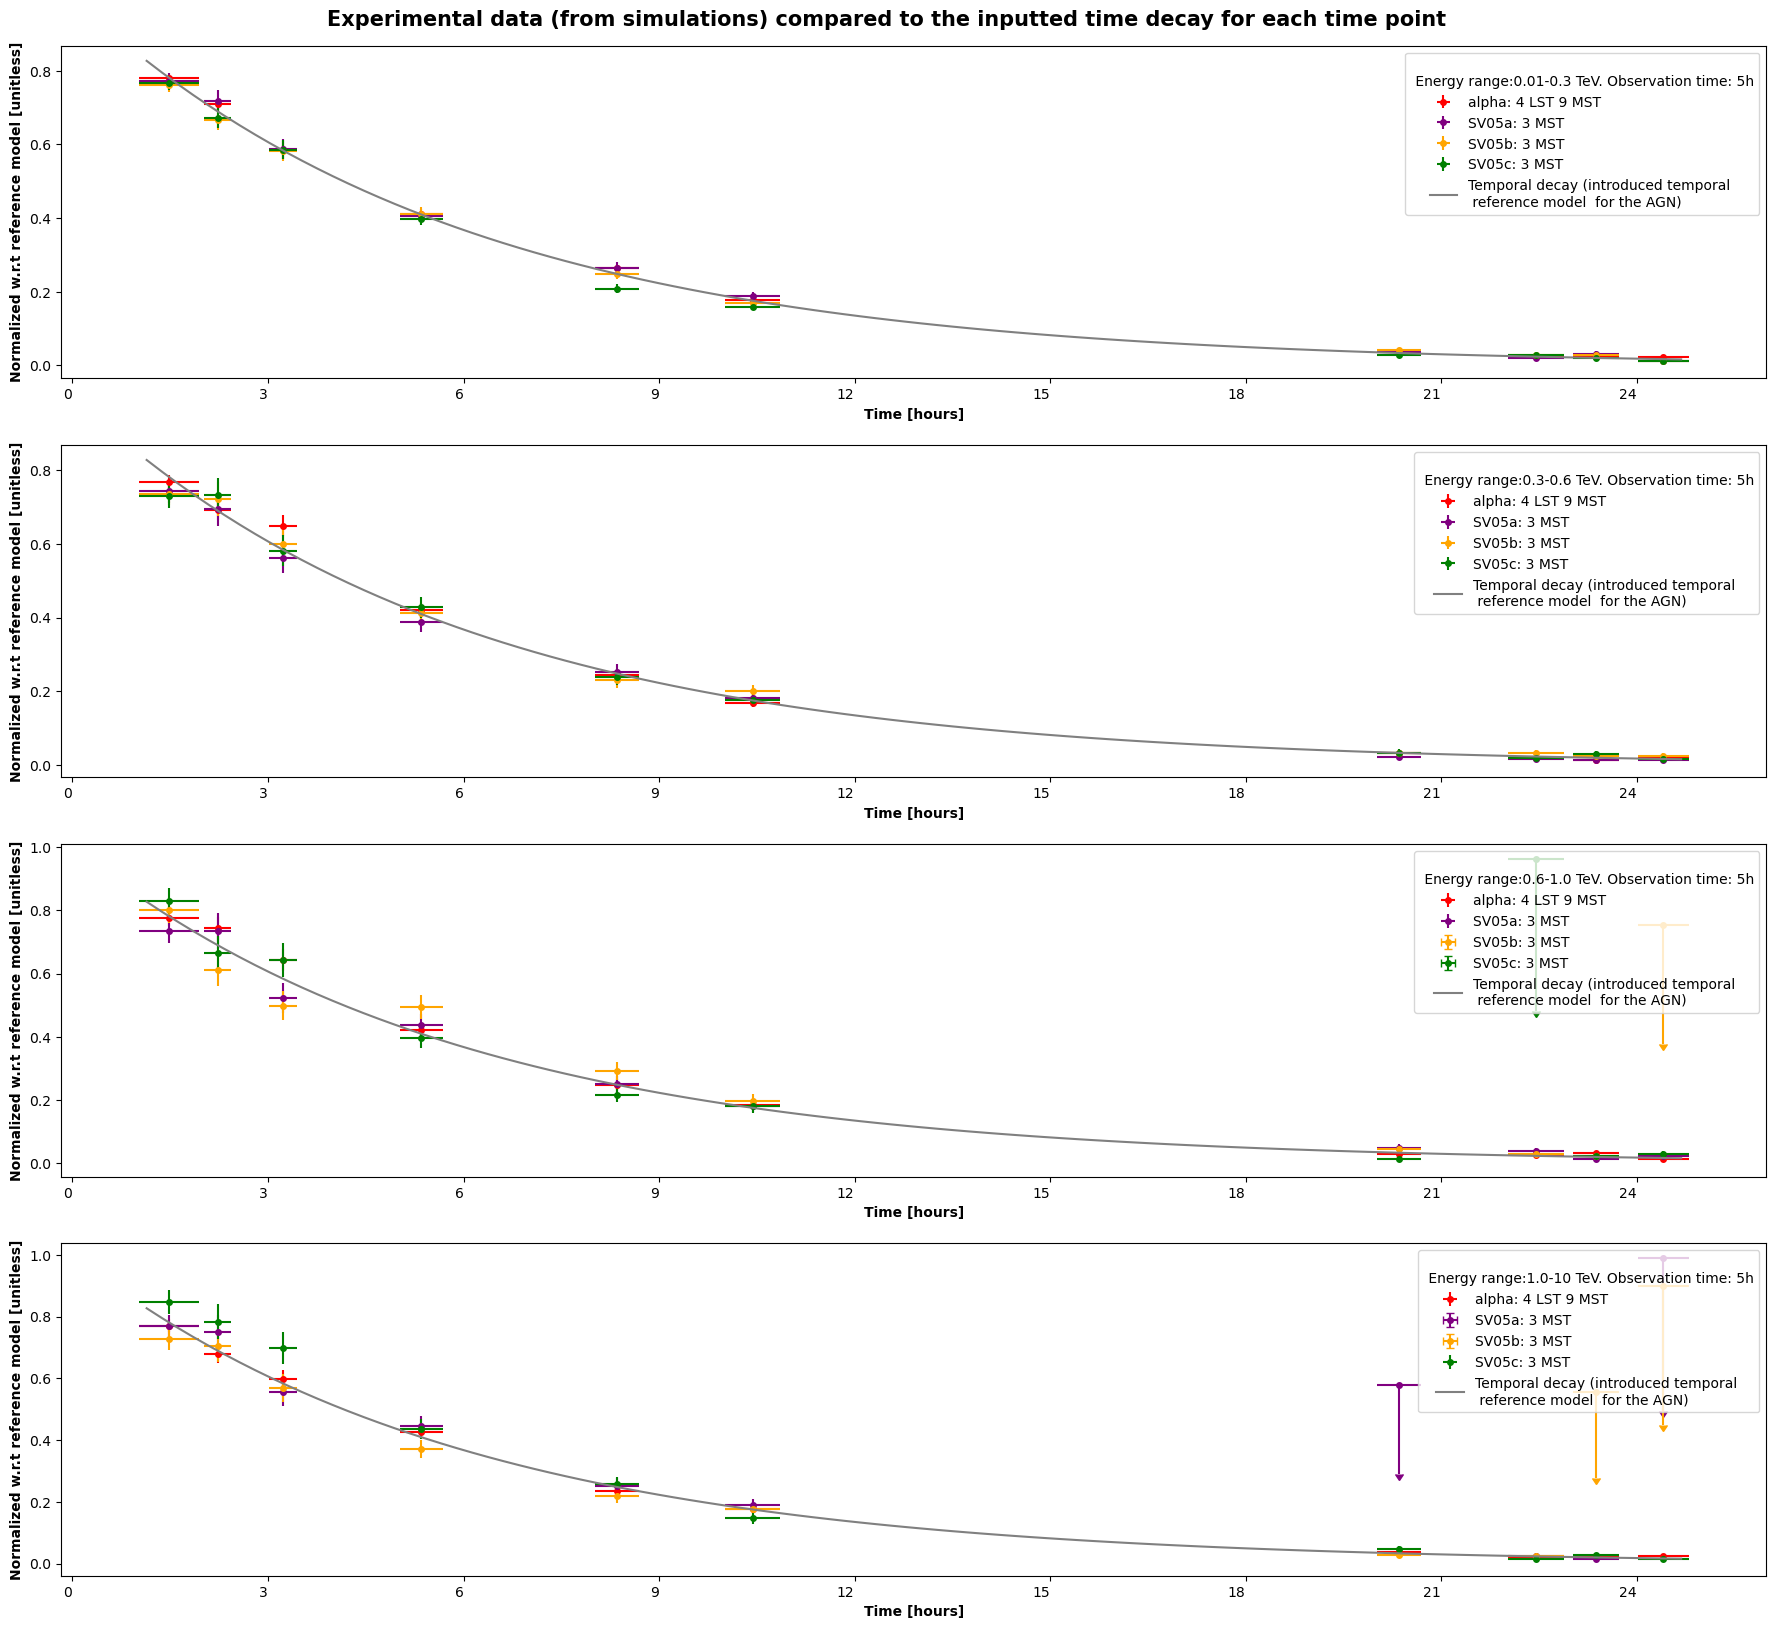

In [7]:
#PREPARING THE DATA TO BE PLOTTED TO COMPARED WITH THE INPUTTED DECAY
#LIGHT CURVE NORMALIZED EXPERIMENTAL (SIMULATED AS WELL) DATA POINTS COMPARED TO THE INPUTTED TEMPORAL DECAY
min_en_val=0
max_en_val=1
num_energy_bins=len(energy_edges_plot)-1
lc_energy_bin = {}
fig, axes = plt.subplots(num_energy_bins, 1, figsize=(22, 18), sharex=False)  # Add sharex=True
for j, ax in enumerate(axes):
    i=0
    for irffile in final_filelist:

        lc_energy_bin[f'lc_fit_{i}'] = lc_1ddic[f'lc_1d_{i}'].slice_by_idx({"energy": slice(min_en_val+j, max_en_val+j)}) #2,3  
        lc_energy_bin[f'lc_fit_{i}'].plot(ax=ax, sed_type="norm", axis_name="time", color=colors[i], label=legendsdic[i])
        i=i+1
        #
    time_range = lc_energy_bin['lc_fit_0'].geom.axes["time"].time_bounds 
    temporal_model.plot(ax=ax, time_range=time_range, label="Temporal decay (introduced temporal \n reference model  for the AGN)", color='gray')

    #
    ax.set_yscale("linear")
    ax.set_xlabel('Time [hours]', fontweight='bold')
    ax.set_ylabel('Normalized w.r.t reference model [unitless]', fontweight='bold')
    legend=ax.legend()
    if legend:
        for label in legend.get_texts():
            label.set_fontweight('bold')
    time_labels = ['0', '3', '6', '9', '12', '15', '18', '21', '24']

    ax.set_xticklabels(time_labels,  rotation=0)
    ax.legend(title=f'\n Energy range:{energy_edges_plot[j]}-{energy_edges_plot[j+1]} TeV. Observation time: {obs_times}', loc='upper right')
fig.suptitle("Experimental data (from simulations) compared to the inputted time decay for each time point", fontsize=15, fontweight='bold')
plt.subplots_adjust(top=0.96)
plt.show()
warnings.filterwarnings('ignore')

## Fit to the datasets 

In [8]:
# FIT TO DATA SETS 

resultfitdsminuit2= {}

for i, _file in enumerate(final_filelist):

    #WE FIT THE AMPLITUDE, SPECTRAL INDEX AND DECAY TIME
    # Define the model with the seed parameters to run the fit:
    spectral_modelseed = PowerLawSpectralModel(
        index=2.0, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
    )
    temporal_modelseed = ExpDecayTemporalModel(t0="10 h", t_ref=gti_t0.mjd * u.d)

    modelseed = SkyModel(
        spectral_model=spectral_modelseed,
        temporal_model=temporal_modelseed,
        name="model-test",
    )
    datasetssim[f'datasim_{i}'].models = modelseed
    #MINUIT 2
    
    fit = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": fitting_strategy_minuit} 
    fit.backend = "minuit"
    fit.optimize_opts = minuit_opts
    resultfitdsminuit2[f"fit_{i}"] = fit.run(datasets=datasetssim[f'datasim_{i}']) #resultfitlc[f"fit_lc_{i}"] = fit.run(datasets=datasetsdic[f"dataset_{i}"])
    

In [9]:
resultfitdsminuit2["fit_0"]

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 325
	total stat : -309701.58

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [10]:
print('Original model parameters:')
display(spectral_model.parameters.to_table())
# We check whether the made fit is consisten between fitting flux points and datasets
print('Parameters obtained fitting the model with each one of the configurations:')
for i, file in enumerate(final_filelist):
    print(f'{i}^th configuration fitted parameters:')
    display(resultfitdsminuit2[f"fit_{i}"].parameters.to_table())




Original model parameters:


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str22,int64,float64,float64,bool,bool,str1
spectral,index,2.2000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,2.0000e+00,10**-10 cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


Parameters obtained fitting the model with each one of the configurations:
0^th configuration fitted parameters:


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.1995e+00,,4.710e-03,nan,nan,False,False,
spectral,amplitude,1.9918e-10,cm-2 s-1 TeV-1,2.454e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,6.1280e+00,h,5.761e-02,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


1^th configuration fitted parameters:


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.2016e+00,,9.397e-03,nan,nan,False,False,
spectral,amplitude,1.9738e-10,cm-2 s-1 TeV-1,4.110e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,6.0673e+00,h,1.059e-01,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


2^th configuration fitted parameters:


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.2138e+00,,9.740e-03,nan,nan,False,False,
spectral,amplitude,1.8865e-10,cm-2 s-1 TeV-1,4.040e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,6.2232e+00,h,1.107e-01,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


3^th configuration fitted parameters:


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.1691e+00,,9.399e-03,nan,nan,False,False,
spectral,amplitude,2.1118e-10,cm-2 s-1 TeV-1,4.476e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,5.7992e+00,h,1.022e-01,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


In [11]:
num_data_points_fit = {} 
reduced_chi2 = {}      
aic_dict = {} 
log_likelihood_dict = {}
i=0
for key, fit_result in resultfitdsminuit2.items():
    log_likelihood = fit_result.total_stat  # This is the difference between values and it's the -2*log-likelihood
    log_likelihood_dict[f"fit_config_{i}"] : dict = log_likelihood
    n_parameters = len(fit_result.models[0].parameters.free_parameters)
    i=i+1
print(f'Minuit {fitting_strategy_minuit}')
print('Log-likelihood values:')
display(log_likelihood_dict)


Minuit 2
Log-likelihood values:


{'fit_config_0': -309701.57546912954,
 'fit_config_1': -73646.17099238744,
 'fit_config_2': -73737.1003799649,
 'fit_config_3': -76365.87875978572}

AIC values:


{'fit_config_0': -309695.57546912954,
 'fit_config_1': -73640.17099238744,
 'fit_config_2': -73731.1003799649,
 'fit_config_3': -76359.87875978572}